In [205]:
import pysam
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [206]:

NM_PERCENTAGE_THRESHOLD = 0.1 # Contigs will be hidden and excluded from statistics if NM_percentage >= NM_PERCENTAGE_THRESHOLD; parameter used to exclude mismapped contigs
INSERTION_THRESHOLD = 10 # Insertions will hidden if length < INSERTION_THRESHOLD
INSERTION_THRESHOLD_2 = 100 # Insertions will be highlighted if length >= INSERTION_THRESHOLD_2
DELETION_THRESHOLD = 1 # Delections will not be displayed if length < DELETION_THRESHOLD
ALIGN_CONTINGENCY = 10 # Blocks will not be displayed if length < ALIGN_CONTINGENCY

RECTANGLE_HEIGHT = 0.2
INTER_ASSEMBLY_PADDING = 1
X_PADDING = 0.05

In [266]:
class Canvas:
    def __init__(self):
        self.assemblies = []
        self.y = 0 - INTER_ASSEMBLY_PADDING
        self.left_limit = None
        self.right_limit = None
        
    def add_assembly(self, assembly):
        assembly.y0 = self.y + INTER_ASSEMBLY_PADDING
        self.assemblies.append(assembly)
        self.y = max([assembly.y_max for assembly in self.assemblies])
        
    def draw(self): 
        # Determine x and y limits
        x_min = None
        x_max = None
        y_max = 0
        
        for assembly in self.assemblies:
            if x_min is None or x_min > assembly.left:
                x_min = assembly.left
            if x_max is None or x_max < assembly.right:
                x_max = assembly.right
            if y_max < assembly.y_max + assembly.y0:
                y_max = assembly.y_max + assembly.y0
        if self.left_limit and self.right_limit:
            x_min = self.left_limit
            x_max = self.right_limit
        
        # Create figure
        plt.figure(figsize = (10, 0.5 * y_max))
        
        # Plot assemblies
        for assembly in self.assemblies:
            assembly.draw()
        
        # Set x and y limits
        delta_x = X_PADDING * (x_max - x_min)
        plt.xlim(x_min - delta_x, x_max + delta_x)
        
        plt.ylim(0, y_max + 1)
        
        # Label assemblies
        for assembly in self.assemblies:
            plt.text(x_max, assembly.y0 + 0.05, assembly.name, ha = 'right', va = 'bottom')
        
        # Hide ticks on y axis
        plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
        # Misc
        plt.xlabel("Reference postition")
        plt.tight_layout()
        
    def limit_region(self, target_region):
        # Remove contigs outside the target region
        self.left_limit, self.right_limit = target_region
        for assembly in self.assemblies:
            for row in assembly.rows:
                row.contigs = [contig for contig in row.contigs if contig.right >= self.left_limit and contig.left <= self.right_limit]
            
            assembly.compute_statistics(target_region)
                
        
    def __repr__(self):
        output = ""
        for assembly in self.assemblies:
            output += assembly.__repr__()
        return output
    

class Assembly:
    def __init__(self, y0 = 0, name = ""):
        self.rows = []
        self.name = name
        self.y0 = y0
        self.y_max = 0
        self.left = None
        self.right = None
        
    def add_contig(self, contig):
        if contig.NM_percentage >= NM_PERCENTAGE_THRESHOLD:
            return
        
        if self.left is None or self.left > contig.left:
            self.left = contig.left
        if self.right is None or self.right < contig.right:
            self.right = contig.right
            
        # Try to insert contig into one of the existing rows
        for row in self.rows:
            if row.check_overlap(contig) == False:
                row.add_contig(contig)
                return
        
        # Otherwise, create a new row and add the contig
        y = self.y_max + 1
        new_row = self.add_row(y)
        self.y_max = y
        new_row.add_contig(contig)
        
        self.compute_statistics()
    
    def compute_statistics(self, target_region = None):
        self.contigs = []
        for row in self.rows:
            self.contigs += row.contigs
        
        # NM
        self.NM = sum([contig.NM for contig in self.contigs])
        self.total_contig_width = sum([contig.width for contig in self.contigs])
        self.NM_percentage = self.NM / self.total_contig_width
        
        if not target_region:
            return
        
        ref_left = target_region[0]
        ref_right = target_region[1]
        ref_size = ref_right - ref_left + 1
        
        # NG50
        self.contigs.sort(key = lambda contig: contig.width, reverse = True)
        
        total_width = 0
        self.NG50 = 0
        for contig in self.contigs:
            total_width += contig.width
            if total_width >= 0.5 * ref_size:
                self.NG50 = contig.width
                break
                
        # Ref_coverage
        ref_covered = [False for position in range(ref_right - ref_left + 1)]
        for contig in self.contigs:
            contig_start = contig.left - ref_left
            contig_end = contig.right - ref_left
            if contig_start < 0:
                contig_start = 0
            if contig_end > ref_right - ref_left:
                contig_end = ref_right - ref_left
            for i in range(contig_start, contig_end + 1):
                ref_covered[i] = True
        self.ref_coverage = sum(ref_covered) / ref_size
            

    def add_row(self, y):
        new_row = Row(y)
        self.rows.append(new_row)
        return new_row

    def draw(self):
        for row in self.rows:
            row.draw(self.y0)
            
        # Draw a horizontal seperating line
        plt.gca().axhline(y = self.y0, linewidth=1, color='whitesmoke')

    def __repr__(self):
        output = "Assembly {name} (y0 = {y0}; NM% = {NM_percentage}; NG50 = {NG50}; Ref_coverage% = {ref_coverage})\n".format(
            name=self.name, y0=self.y0, NM_percentage = round(self.NM_percentage * 100, 2), 
            NG50 = self.NG50, ref_coverage = round(self.ref_coverage * 100, 2))
        for row in self.rows:
            output += row.__repr__()
        return output
        

class Row:
    def __init__(self, y):
        self.y = y
        self.contigs = []
        
    def check_overlap(self, contig, padding = 10):
        overlapped = False
        for existing_contig in self.contigs:
            if contig.left >= existing_contig.left - padding and contig.left <= existing_contig.right + padding or \
            contig.right >= existing_contig.left - padding and contig.right <= existing_contig.right + padding:
                overlapped = True
        return overlapped
    
    def add_contig(self, contig):
        self.contigs.append(contig)
        
    def draw(self, y0):
        for contig in self.contigs:
            contig.draw(self.y + y0)
            
    def __repr__(self):
        output = "\tRow {y}\n".format(y = self.y)
        for contig in self.contigs:
            output += contig.__repr__() + "\n"
        return output
            
            

class Contig:
    def __init__(self, contig_data):
        self.blocks = []
        self.left = None
        self.right = None
        self.width = None

        # Add blocks
        blocks_data = contig_data.get_blocks()
        for block_data in blocks_data:
            left, right = block_data[0], block_data[1]
            block = Block(left, right)
            self.add_block(block)
            
        # Add insertions and deletions
        aligned_pairs = contig_data.get_aligned_pairs()
        self.insertions = detect_insertions(aligned_pairs)
        self.deletions = detect_deletions(aligned_pairs)
        
        # Compute statictics
        self.NM = contig_data.get_tag('NM')
        self.NM_percentage = self.NM / self. width
        
        # self.NM_percentage = sum([block.width + 1 for block in self.blocks]) / (self.width + 1)
        
        
    def add_block(self, block):
        self.blocks.append(block)
        if self.left is None or self.left > block.left:
            self.left = block.left
        if self.right is None or self.right < block.left:
            self.right = block.right
        self.width = self.right - self.left
            
    def draw(self, y):
        
        # Draw a line across the contig
        width = self.right - self.left
        line_height = 0.05
        ax = plt.gca()
        global RECTANGLE_HEIGHT
        ax.add_patch(patches.Rectangle((self.left, y + 0.5 * RECTANGLE_HEIGHT - 0.5 * line_height), 
                                       width, line_height, facecolor = "firebrick", edgecolor=None, zorder=0.8))
        for block in self.blocks:
            block.draw(y)
        
        if self.insertions:
            for insertion in self.insertions:
                insertion.draw(y)
        
        if self.deletions:
            for deletion in self.deletions:
                deletion.draw(y)
        
            
    def __repr__(self):
        return "\t\tContig {left}-{right} (NM% = {NM}; {n_insertion} insertions; {n_deletion} deletions; {n} blocks) ".format(
            left = self.left, right = self.right, n = len(self.blocks),
            NM = round(self.NM_percentage * 100, 2), n_insertion = len(self.insertions), n_deletion = len(self.deletions))

class Block:
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.width = self.right - self.left + 1
        self.y = None
        
    def draw(self, y):
        if self.right - self.left < ALIGN_CONTINGENCY:
            return
        else:
            rectangle_color = "steelblue"
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=1, facecolor=rectangle_color, edgecolor=None))
        
class Insertion:
    def __init__(self, position, length):
        self.position = position
        self.length = length
    def draw(self, y):
        global INSERTION_THRESHOLD
        if self.length < INSERTION_THRESHOLD:
            return
        if not self.position or not y:
            return
        if self.length >= INSERTION_THRESHOLD_2:
            marker_color = 'red'
        else:
            marker_color = 'purple'
        plt.plot(self.position, y, marker = align_marker("^", valign="top"), color=marker_color, markersize=10, markeredgewidth=0)
        
    def __repr__(self):
        return "Insertion(position = {position}, length = {length})".format(
            position = self.position, length = self.length)
    
class Deletion():
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.width = self.right - self.left + 1
    def __repr__(self):
        output = "Deletion(width = {width}) ".format(width = self.width)
        return output
    def draw(self, y):
        if self.width < DELETION_THRESHOLD:
            return
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=2, facecolor='red', edgecolor=None))

In [267]:
def detect_insertions(aligned_pairs):
    # How to distinguish between small deletions and poorly assemblied regions?
    length = 0
    position = 0
    insertions = []
    for query, reference in aligned_pairs:
        if query and not reference:
            if length == 0: # Start of a new insertion              
                pass
            else: # Continue current insertion
                pass
            length += 1
            
        else:
            if length == 0: # Matched pair; record position
                position = reference
            else: # End current insertion
                insertions.append(Insertion(position, length))
                position = 0
                length = 0
    return insertions

        

In [268]:
def detect_deletions(aligned_pairs):
    deletions = []
    left = None
    right = None
    for query, reference in aligned_pairs:
        if reference and not query: 
            if not left: # Start of a new deletion
                left = reference
                right = left + 1
            else: # Continue current deletion
                right = reference
        else:
            if not left: # Matched pair; record position
                pass
            else: # End current insertion
                deletions.append(Deletion(left, right))
                left = None
                right = None
    return deletions
        

In [269]:
from matplotlib import markers
from matplotlib.path import Path

def align_marker(marker, halign='center', valign='middle',):
    """
    create markers with specified alignment.
    From: https://stackoverflow.com/questions/26686722/align-matplotlib-scatter-marker-left-and-or-right

    Parameters
    ----------

    marker : a valid marker specification.
      See mpl.markers

    halign : string, float {'left', 'center', 'right'}
      Specifies the horizontal alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'center',
      -1 is 'right', 1 is 'left').

    valign : string, float {'top', 'middle', 'bottom'}
      Specifies the vertical alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'middle',
      -1 is 'top', 1 is 'bottom').

    Returns
    -------

    marker_array : numpy.ndarray
      A Nx2 array that specifies the marker path relative to the
      plot target point at (0, 0).

    Notes
    -----
    The mark_array can be passed directly to ax.plot and ax.scatter, e.g.::

        ax.plot(1, 1, marker=align_marker('>', 'left'))

    """

    if isinstance(halign, (bytes, str)):
        halign = {'right': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'left': 1.,
                  }[halign]

    if isinstance(valign, (bytes, str)):
        valign = {'top': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'bottom': 1.,
                  }[valign]

    # Define the base marker
    bm = markers.MarkerStyle(marker)

    # Get the marker path and apply the marker transform to get the
    # actual marker vertices (they should all be in a unit-square
    # centered at (0, 0))
    m_arr = bm.get_path().transformed(bm.get_transform()).vertices

    # Shift the marker vertices for the specified alignment.
    m_arr[:, 0] += halign / 2
    m_arr[:, 1] += valign / 2

    return Path(m_arr, bm.get_path().codes)

In [270]:
def read_bam_file(bam_file, assembly_name = None):
    if not assembly_name: 
        # Use bamfile name without extension as assembly name
        base_name = os.path.basename(bam_file)
        assembly_name = os.path.splitext(base_name)[0]
    assembly = Assembly(name = assembly_name)
    bam = pysam.AlignmentFile(bam_file, 'rb')
    
    contigs = []
    for contig_data in bam.fetch():
        contig = Contig(contig_data)    
        contigs.append(contig)
    
    # Sort contigs by width to ensure longer contigs are plotted before shorter contigs
    contigs.sort(key = lambda contig: contig.width, reverse=True)
    for contig in contigs:
        assembly.add_contig(contig)
    return assembly

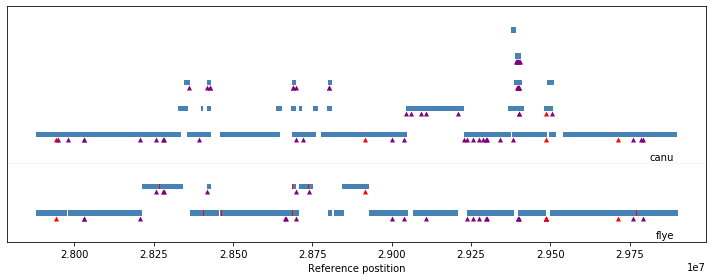

In [271]:
assembly = read_bam_file("data/IL27/flye.bam")
assembly2 = read_bam_file("data/IL27/canu.bam")
canvas = Canvas()
canvas.add_assembly(assembly)
canvas.add_assembly(assembly2)
canvas.limit_region((27888679, 29888679))
canvas.draw()

plt.savefig("1.svg")

In [272]:
canvas

Assembly flye (y0 = 0; NM% = 1.19; NG50 = 141619; Ref_coverage% = 92.39)
	Row 1
		Contig 29498739-29901058 (NM% = 1.17; 45 insertions; 359 deletions; 404 blocks) 
		Contig 27979949-28213983 (NM% = 0.71; 27 insertions; 122 deletions; 149 blocks) 
		Contig 28458068-28656985 (NM% = 0.99; 28 insertions; 158 deletions; 186 blocks) 
		Contig 29236568-29385329 (NM% = 1.03; 42 insertions; 79 deletions; 121 blocks) 
		Contig 29067393-29209012 (NM% = 0.72; 37 insertions; 69 deletions; 106 blocks) 
		Contig 28927451-29051025 (NM% = 1.14; 7 insertions; 108 deletions; 115 blocks) 
		Contig 27877925-27976915 (NM% = 1.86; 11 insertions; 48 deletions; 59 blocks) 
		Contig 29396994-29486875 (NM% = 1.98; 54 insertions; 95 deletions; 149 blocks) 
		Contig 28658279-28709361 (NM% = 2.16; 15 insertions; 58 deletions; 73 blocks) 
		Contig 28405943-28456774 (NM% = 1.38; 12 insertions; 57 deletions; 69 blocks) 
		Contig 28363508-28405862 (NM% = 0.97; 8 insertions; 36 deletions; 44 blocks) 
		Contig 28817853-28

In [265]:
l = [1,2,3,4]
l[1:2] = 1

TypeError: can only assign an iterable

In [26]:
bam_file = "data/IL27/flye.bam"
bam = pysam.AlignmentFile(bam_file, 'rb')
contigs = [contig for contig in bam.fetch()]
help(contigs[1])
contigs[1].header

Help on AlignedSegment object:

class AlignedSegment(builtins.object)
 |  AlignedSegment(AlignmentHeader header=None)
 |  Class representing an aligned segment.
 |  
 |      This class stores a handle to the samtools C-structure representing
 |      an aligned read. Member read access is forwarded to the C-structure
 |      and converted into python objects. This implementation should be fast,
 |      as only the data needed is converted.
 |  
 |      For write access, the C-structure is updated in-place. This is
 |      not the most efficient way to build BAM entries, as the variable
 |      length data is concatenated and thus needs to be resized if
 |      a field is updated. Furthermore, the BAM entry might be
 |      in an inconsistent state.
 |  
 |      One issue to look out for is that the sequence should always
 |      be set *before* the quality scores. Setting the sequence will
 |      also erase any quality scores that were set previously.
 |  
 |      Parameters
 |      --

In [32]:
contig = contigs[1]
tags = contig.get_tags()
tags

[('NM', 1656),
 ('ms', 460610),
 ('AS', 460632),
 ('nn', 0),
 ('tp', 'P'),
 ('cm', 37508),
 ('s1', 210541),
 ('s2', 788),
 ('de', 0.0015999999595806003)]

In [30]:
type(tags)

list

In [33]:
contig.get_tag('NM')

1656

In [229]:
help(zeros)

NameError: name 'zeros' is not defined

In [230]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |